# Background
Dataset: https://www.takakura.com/Kyoto_data/new_data201704/

In [16]:
# Necessary imports
import pandas as pd
import os
import warnings
from shutil import rmtree
import seaborn as sb
import matplotlib.pyplot as plt

# Pre-processing

### Converting the data from txt format to CSV format to make the data easier to work with

In [11]:
# Since our data has mixed attribute types, we suppress the pandas warning regarding it
warnings.simplefilter(action='ignore', category=pd.errors.DtypeWarning)

# From the data documentation
columns = [
    "Duration (seconds)",
    "Service Type",
    "Source bytes",
    "Destination bytes",
    "Count",
    "Same srv rate",
    "Serror rate",
    "Srv serror rate",
    "Dst host count",
    "Dst host srv count",
    "Dst host same src port rate",
    "Dst host serror rate",
    "Dst host srv serror rate",
    "Flag",
    "IDS detection",
    "Malware detection",
    "Ashula detection",
    "Label",
    "Source IP Address",
    "Source Port Number",
    "Destination IP Address",
    "Destination Port Number",
    "Start Time",
    "Protocol"
]

# Delete the CSVs folder if it already exists
rmtree("Data/CSVs/", ignore_errors = True)
# Make it again
os.mkdir("Data/CSVs/")

# Since we're iterating through all months in the year
for month in range(1, 13):
    month_encoder = {
        1: "January",
        2: "February",
        3: "March",
        4: "April",
        5: "May",
        6: "June",
        7: "July",
        8: "August",
        9: "September",
        10: "October",
        11: "November",
        12: "December"
    }
    print(f"Creating {month_encoder[month]}.csv...")
    output_file = f"Data/CSVs/{month_encoder[month]}.csv"
    if month < 10:
        str_month = "0"+str(month)    # Since months are 2 digits in the file structure
    else:
        str_month = str(month)
    
    for data_file in os.listdir(f"Data/{str(str_month)}"):
        file_path = os.path.join(f"Data/{str(str_month)}", data_file)
        # Read the TXT using tab delimiters since that's how it's structured
        day_data = pd.read_csv(file_path, delimiter="\t", names=columns, index_col=False)
        # If [month].csv doesn't exist yet, create it
        if not os.path.exists(output_file):
            day_data.to_csv(output_file, mode='w', header=True, index=False)
        # Or else append to it
        else:
            day_data.to_csv(output_file, mode='a', header=False, index=False)

Creating January.csv...
Creating February.csv...
Creating March.csv...
Creating April.csv...
Creating May.csv...
Creating June.csv...
Creating July.csv...
Creating August.csv...
Creating September.csv...
Creating October.csv...
Creating November.csv...
Creating December.csv...


## Inspecting the data

Inspection of data for January:
Data Attributes:

Duration (seconds)	|	Service Type	|	Source bytes	|	Destination bytes	|	Count	|	Same srv rate
Serror rate	|	Srv serror rate	|	Dst host count	|	Dst host srv count	|	Dst host same src port rate	|	Dst host serror rate
Dst host srv serror rate	|	Flag	|	IDS detection	|	Malware detection	|	Ashula detection	|	Label
Source IP Address	|	Source Port Number	|	Destination IP Address	|	Destination Port Number	|	Start Time	|	Protocol


First five rows of the dataset:
   Duration (seconds) Service Type  Source bytes  Destination bytes  Count  \
0            0.000000        other             0                  0      0   
1            0.000000        other             0                  0      0   
2            2.495048        other             0                  0      1   
3           29.124205        other            40                  0      0   
4            0.000000        other             0                  0      0   

   ...  Source Port Numb

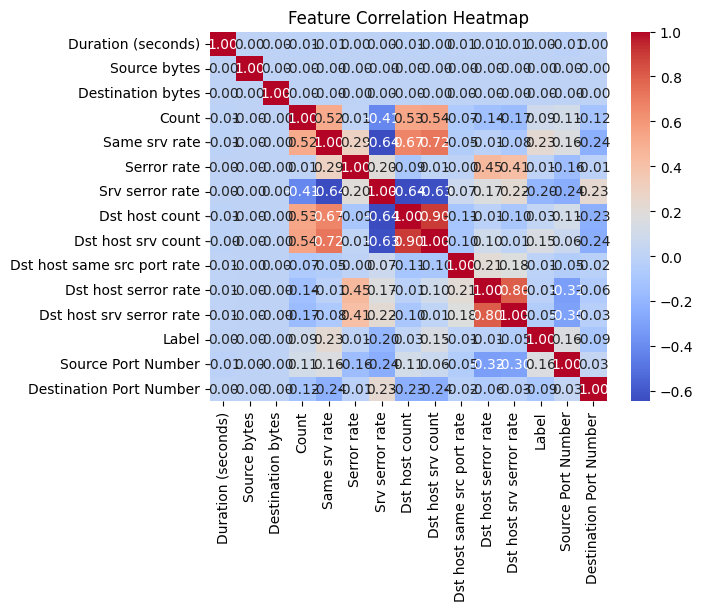

In [27]:
def inspect_data(month):
    print("Inspection of data for " + month + ":")
    
    # Load the Data
    file_path = f"Data/CSVs/{month}.csv"
    data = pd.read_csv(file_path, index_col = False)

    # Print the table attributes
    print("Data Attributes:\n")
    attributes = data.columns.tolist()
    for i in range(0, len(attributes), 6):
        print("\t|\t".join(attributes[i:i+6]))
    #print("Attributes: " + ''.join(data.columns.tolist()))
    #print(data.columns.tolist())

    # Initial Data Summary
    print("\n\nFirst five rows of the dataset:")
    with pd.option_context('display.max_columns', 10):
        print(data.head(5)) 

    # Print statistocs of numerical features
    for column in data.select_dtypes(include='number').columns:
        print(f"\nStatistics for Numerical Feature {column}:")
        print(data[column].describe())

    # Print the number of missing values in each column
    for column in data.columns:
        missing_count = data[column].isnull().sum()
        print(f"Column '{column}' has {missing_count} missing values")

    # Print the unique values of categorical features
    for column in data.select_dtypes(include='object').columns:
        unique_values = data[column].nunique()
        print(f"Unique values in {column}: {unique_values}")


    # Correlations matrix between numerical features
    print("\nCorrelation Matrix:")
    correlation_matrix = data.select_dtypes(include='number').corr()
    sb.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
    plt.title("Feature Correlation Heatmap")
    plt.show()

    """# Visualize Categorical Data Distributions
    for column in data.select_dtypes(include='object').columns:
        plt.figure()
        plt.title(f"Count Plot of {column}")
        sb.countplot(y=column, data=data)
        plt.show()"""

    """# Visualize Relationships Between Features
    # Example: Scatter Plot of Two Important Features
    if 'Duration' in data.columns and 'Label' in data.columns:
        plt.figure()
        plt.scatter(data['Duration'], data['Label'], alpha=0.5)
        plt.title('Duration vs. Label')
        plt.xlabel('Duration')
        plt.ylabel('Label')
        plt.show()"""

inspect_data("January")

# Modeling

# Post-processing

# Analysis + Accuracy